Moist isentropic flow past an isolated obstacle
==

In [1]:
from datetime import timedelta
import gridtools as gt
import numpy as np
import os
import tasmania as taz

# Interactive plotting
from IPython import display
%matplotlib nbagg

import namelist_isentropic_moist as nl

The underlying grid
--

In [2]:
grid = taz.GridXYZ(
    nl.domain_x, nl.nx, nl.domain_y, nl.ny, nl.domain_z, nl.nz,
    topo_type=nl.topo_type, topo_time=nl.topo_time, topo_kwargs=nl.topo_kwargs,
    dtype=nl.dtype
)

The initial state
--

In [3]:
if nl.isothermal:
    state = taz.get_isothermal_isentropic_state(
        grid, nl.init_time, nl.init_x_velocity, nl.init_y_velocity,
        nl.init_temperature, moist=True, precipitation=nl.precipitation, 
        dtype=nl.dtype
    )
else:
    state = taz.get_default_isentropic_state(
        grid, nl.init_time, nl.init_x_velocity, nl.init_y_velocity,
        nl.init_brunt_vaisala, moist=True, precipitation=nl.precipitation, 
        dtype=nl.dtype
    )

The intermediate tendencies
--

In [4]:
args = []

# Component calculating the pressure gradient in isentropic coordinates
order = 4 if nl.horizontal_flux_scheme == 'fifth_order_upwind' else 2
pg = taz.ConservativeIsentropicPressureGradient(
    grid, order=order,
    horizontal_boundary_type=nl.horizontal_boundary_type,
    backend=nl.backend, dtype=nl.dtype
)
args.append(pg)

# Component calculating the microphysics
ke = taz.Kessler(
    grid, air_pressure_on_interface_levels=True,
    rain_evaporation=nl.rain_evaporation, backend=nl.backend
)
args.append(ke)

if nl.precipitation:
    # Component estimating the raindrop fall velocity
    rfv = taz.RaindropFallVelocity(grid, backend=nl.backend)
    args.append(rfv)

    # Component integrating the sedimentation flux
    sd = taz.Sedimentation(
        grid, sedimentation_flux_scheme='second_order_upwind',
        backend=nl.backend
    )
    args.append(sd)

    if nl.rain_evaporation:
        # Component integrating the vertical flux
        vf = taz.VerticalIsentropicAdvection(
            grid, moist=True, flux_scheme=nl.vertical_flux_scheme,
            tendency_of_air_potential_temperature_on_interface_levels=False,
            backend=nl.backend
        )
        args.append(vf)

if nl.coriolis:
    # Component calculating the Coriolis acceleration
    cf = taz.ConservativeIsentropicCoriolis(
        grid, coriolis_parameter=nl.coriolis_parameter, dtype=nl.dtype
    )
    args.append(cf)

# Wrap the components in a ConcurrentCoupling object
inter_tends = taz.ConcurrentCoupling(*args, execution_policy='serial')

The intermediate diagnostics
--

In [5]:
# Component retrieving the diagnostic variables
pt = state['air_pressure_on_interface_levels'][0, 0, 0]
dv = taz.IsentropicDiagnostics(
    grid, moist=True, pt=pt, backend=nl.backend, dtype=nl.dtype
)

# Component performing the saturation adjustment
sa = taz.SaturationAdjustmentKessler(
    grid, air_pressure_on_interface_levels=True, backend=nl.backend
)

# Wrap the components in a DiagnosticComponentComposite object
inter_diags = taz.DiagnosticComponentComposite(dv, sa)

The dynamical core
--

In [6]:
dycore = taz.HomogeneousIsentropicDynamicalCore(
    grid, time_units='s', moist=True,
    # parameterizations
    intermediate_tendencies=inter_tends, intermediate_diagnostics=inter_diags,
    substeps=nl.substeps, fast_tendencies=None, fast_diagnostics=None,
    # numerical scheme
    time_integration_scheme=nl.time_integration_scheme,
    horizontal_flux_scheme=nl.horizontal_flux_scheme,
    horizontal_boundary_type=nl.horizontal_boundary_type,
    # vertical damping
    damp=nl.damp, damp_type=nl.damp_type, damp_depth=nl.damp_depth,
    damp_max=nl.damp_max, damp_at_every_stage=nl.damp_at_every_stage,
    # horizontal smoothing
    smooth=nl.smooth, smooth_type=nl.smooth_type,
    smooth_damp_depth=nl.smooth_damp_depth,
    smooth_coeff=nl.smooth_coeff, smooth_coeff_max=nl.smooth_coeff_max,
    smooth_at_every_stage=nl.smooth_at_every_stage,
    # horizontal smoothing of water species
    smooth_moist=nl.smooth_moist, smooth_moist_type=nl.smooth_moist_type,
    smooth_moist_damp_depth=nl.smooth_moist_damp_depth,
    smooth_moist_coeff=nl.smooth_moist_coeff,
    smooth_moist_coeff_max=nl.smooth_moist_coeff_max,
    smooth_moist_at_every_stage=nl.smooth_moist_at_every_stage,
    # backend settings
    backend=nl.backend, dtype=nl.dtype
)

A NetCDF monitor
--

In [7]:
if nl.filename is not None:
    if os.path.exists(nl.filename):
        os.remove(nl.filename)
    netcdf_monitor = taz.NetCDFMonitor(nl.filename, grid)
    netcdf_monitor.store(state)

A monitor for visualization purposes
--

In [8]:
u0 = nl.init_x_velocity.to_units('m s^-1').values.item()

# The drawers and the artist generating the left subplot
drawer1_properties = {
    'fontsize': 16, 'cmap_name': 'BuRd', 'cbar_on': True, 
    'cbar_levels': 18, 'cbar_ticks_step': 4, 'cbar_center': u0,
    'cbar_orientation': 'horizontal',
    'cbar_x_label': '$x$-velocity [m s$^{-1}$]',
    'draw_vertical_levels': True,
}
drawer1 = taz.Contourf(
    grid, 'x_velocity', 'm s^-1', y=int(nl.ny/2),
    xaxis_units='km', zaxis_name='height', zaxis_units='km',
    properties=drawer1_properties,
)
topo_drawer = taz.LineProfile(
    grid, 'topography', 'km', y=int(nl.ny/2), z=-1, axis_units='km',
    properties={'linecolor': 'black', 'linewidth': 1.3}
)
axes1_properties = {
    'fontsize': 16, 'title_left': '$y = 0$ km',
    'x_label': '$x$ [km]', 'x_lim': [-250, 250],
    'y_label': '$z$ [km]', 'y_lim': [0, 14],
}
plot1 = taz.Plot((topo_drawer, drawer1), axes_properties=axes1_properties)

# The drawer and the artist generating the right subplot
drawer3_properties = {
    'fontsize': 16, 'cmap_name': 'Blues', 'cbar_on': True, 
    'cbar_levels': 18, 'cbar_ticks_step': 4, 'cbar_center': 0.25,
    'cbar_width': 0.25, 'cbar_orientation': 'horizontal',
    'cbar_x_label': 'Cloud liquid water [g kg$^{-1}$]',
    'draw_vertical_levels': True,
}
drawer3 = taz.Contourf(
    grid, 'mass_fraction_of_cloud_liquid_water_in_air', 'g kg^-1', y=int(nl.ny/2),
    xaxis_units='km', zaxis_name='height', zaxis_units='km',
    properties=drawer3_properties,
)
axes3_properties = {
    'fontsize': 16, 'title_left': '$y = 0$ km',
    'x_label': '$x$ [km]', 'x_lim': [-250, 250],
    'y_label': '$z$ [km]', 'y_lim': [0, 14],
}
plot2 = taz.Plot((topo_drawer, drawer3), axes_properties=axes3_properties)

# The drawer and the artist generating the right subplot
drawer4_properties = {
    'fontsize': 16,
}
drawer4 = taz.LineProfile(
    grid, 'accumulated_precipitation', 'mm', y=int(nl.ny/2), z=-1,
    axis_units='km', properties=drawer4_properties,
)
axes4_properties = {
    'fontsize': 16, 'x_label': '$x$ [km]', 'x_lim': [-250, 250],
}
plot3 = taz.Plot(drawer4, axes_properties=axes4_properties)

# The monitor encompassing and coordinating the two artists
figure_properties = {'fontsize': 16, 'figsize': (12, 7), 'tight_layout': True}
plot_monitor = taz.PlotComposite(
    nrows=1, ncols=2, 
    #artists=(plot1, plot2), 
    artists=(plot1, plot3),
    interactive=False, figure_properties=figure_properties
)

Simulation
--

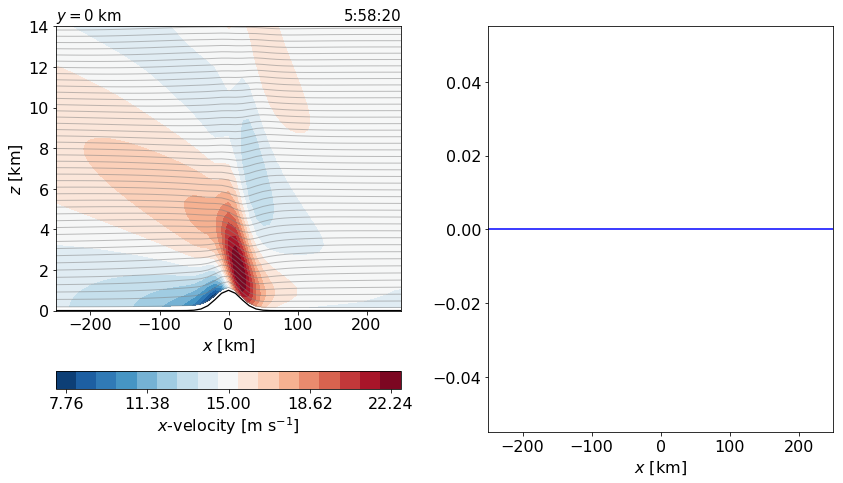

Simulation successfully completed. HOORAY!


In [9]:
# Simulation settings
dt = nl.timestep
nt = nl.niter
 
# Integrate
for i in range(nt):
    # Update the (time-dependent) topography
    dycore.update_topography((i+1) * dt)
  
    # Step the solution
    state_new = dycore(state, {}, dt)
    state.update(state_new)
    
    if (nl.print_frequency > 0) and ((i + 1) % nl.print_frequency == 0):
        u = state['x_velocity_at_u_locations'].to_units('m s^-1').values[...]
        v = state['y_velocity_at_v_locations'].to_units('m s^-1').values[...]
  
        umax, umin = u.max(), u.min()
        vmax, vmin = v.max(), v.min()
        cfl = max(
            umax * dt.total_seconds() / grid.dx.to_units('m').values.item(),
            vmax * dt.total_seconds() / grid.dy.to_units('m').values.item()
        )
 
        # Print useful info
        print(
            'Iteration {:6d}: CFL = {:4f}, umax = {:8.4f} m/s, umin = {:8.4f} m/s, '
            'vmax = {:8.4f} m/s, vmin = {:8.4f} m/s'.format(
                i+1, cfl, umax, umin, vmax, vmin
            )
        )
        
    # Shortcuts
    to_save = (nl.filename is not None) and \
              (((nl.save_frequency > 0) and \
              ((i + 1) % nl.save_frequency == 0)) or i + 1 == nt)
    to_plot = (nl.plot_frequency > 0) and ((i+1) % nl.plot_frequency == 0)
    
    if to_save:
        # Save the solution
        netcdf_monitor.store(state)

    if to_plot:
        # Plot the solution
        plot1.axes_properties['title_right'] = str((i+1)*dt)
        plot2.axes_properties['title_right'] = str((i+1)*dt)
        #fig = plot_monitor.store(((state, state), (state, state)), show=False)
        fig = plot_monitor.store(((state, state), state), show=False)
        display.clear_output(wait=True)
        display.display(fig)
        
print('Simulation successfully completed. HOORAY!')

Post-processing
--

In [10]:
if nl.filename is not None:
    netcdf_monitor.write()